# Exercise 3
Ole Gunnar Hovland and Alexander Hatle

In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

In [22]:
def plot_solution(x, t, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);

In [2]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    if len(v) + len(d) + len(w) > 3:
        A = np.diag(v, -1) + np.diag(d) + np.diag(w, 1)
    else:
        e = np.ones(N)        # array [1,1,...,1] of length N
        A = v*np.diag(e[1:],-1) + d * np.diag(e) + w * np.diag(e[1:],1)
    return A

In [159]:
def crank(g, params, BC, M=10, N=100, R = 1, T=0.5):
    # Input: 
    #       g: initial function for t=0
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x, K)              # Initial values, endpoints included
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C

    # Boundary functions, bnddry0 = u(0, t), bndryR = u(R, t)
    if BC == 'EP':
        U[0, :] = K * np.exp(-c * t)
    elif BC == 'binary':
        U[0, :] = 0 * t
    
    U[-1, :] = np.repeat(U[-1, 0], N+1)

    # Constructing p and q
    p = np.zeros(M-1)
    p[0] = (-alpha * x[0]**2 - beta * x[0]) * U[0,1]
    p[-1] = (-alpha * x[-1]**2 + beta * x[-1]) * U[-1,1]
    q = np.zeros(M-1)
    q[0] = (alpha * x[0]**2 + beta * x[0]) * U[0,0]
    q[-1] = (alpha * x[-1]**2 - beta * x[-1]) * U[-1,0]

    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        tempvec = B.dot(U[1:-1, n]) + q - p 
        U[1:-1, n+1] = np.linalg.solve(A, tempvec)  # [1:-1] -> excluding endpoints
        # Boundary
        #U[0, n+1] = bndry(t[n+1])
    return x, t, U

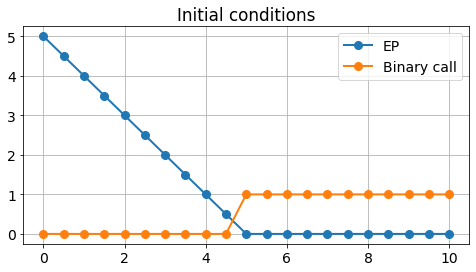

In [160]:
def european_put(x, K):
    sol = K-x
    sol[sol < 0] = 0
    return sol
def binary_call(x, K):
    sol = x-K
    sol[sol >= 0] = 1
    sol[sol < 0] = 0
    return sol

x = np.linspace(0, 10, 21)
K = 5
plt.title('Initial conditions')
plt.plot(x, european_put(x, K), '-o', label = 'EP')
plt.plot(x, binary_call(x, K), '-o', label = 'Binary call')
plt.legend()
plt.show()


h=2.0000, k=0.0200


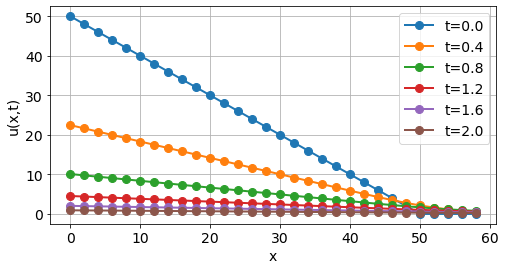

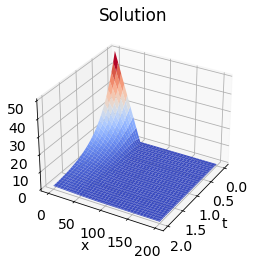

In [161]:
sigma = 0.2
r = 0.2
c = 2
K = 50
params = [sigma, r, c, K]

BC = 'EP'
if BC == 'binary':
    g = binary_call
elif BC == 'EP':
    g = european_put


x, t, U = crank(g = g, params = params, BC = BC, T = 2, R = 200, M = 100, N = 100)

plt.figure(1)
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x[:30],U[:30,n],'-o',label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()

# Make a 3-d plot
plot_solution(x[:], t, U[:, :], txt='Solution')

In [203]:
def crank_modified(g, params, BC, M=10, N=100, R = 1, T=0.5):
    # Input: 
    #       g: initial function for t=0
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values, endpoints included

    # Boundary
    U[0, :] = 0
    U[-1, :] = R**2 * (1 + t)
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C

    # Boundary functions, bnddry0 = u(0, t), bndryR = u(R, t)
    

    # Constructing p and q
    p = np.zeros(M-1)
    p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,1]
    p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,1]
    
    q = np.zeros(M-1)
    q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,0]
    q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,0]

    # RHS
    def f(t):
        return (1+t) * x[1:-1]**2 * (1/(1 + t) - sigma**2 + 2*r + c)

    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        tempvec = B.dot(U[1:-1, n]) + q - p + k * f(t[n])
        U[1:-1, n+1] = np.linalg.solve(A, tempvec)  # [1:-1] -> excluding endpoints
        
    return x, t, U

In [204]:
def u_exact(x, t):
    return (1 + t) * x**2
def u0(x):
    return x**2

In [213]:
x, t, U = crank_modified(g = u0, params = params, BC = BC, T = 2, R = 200, M = 100, N = 100)

h=2.0000, k=0.0200


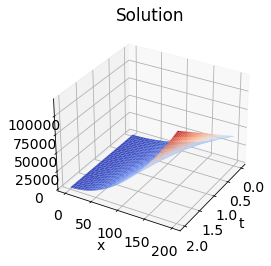

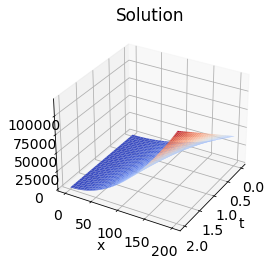

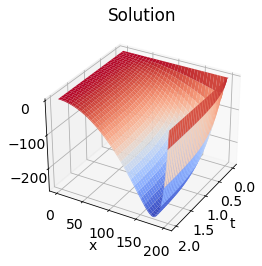

In [214]:
plot_solution(x, t, U)
tt, xx = np.meshgrid(t, x)
plot_solution(x, t, u_exact(xx, tt))
plot_solution(x, t, U - u_exact(xx, tt))